# EDLIF model

[Jaras I, Harada T, Orchard ME, Maldonado PE, Vergara RC. Extending the integrate-and-fire model to account for metabolic dependencies. Eur J Neurosci. 2021 Aug;54(4):5249-5260. doi: 10.1111/ejn.15326. Epub 2021 Jul 16. PMID: 34109698.](https://onlinelibrary.wiley.com/doi/10.1111/ejn.15326)

[Free full article](https://www.researchgate.net/publication/352298690_Extending_the_integrate-and-fire_model_to_account_for_metabolic_dependencies)

### TODO:
- [] include equations

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
import os

from pynestml.frontend.pynestml_frontend import generate_nest_target

NEST_SIMULATOR_INSTALL_LOCATION = nest.ll_api.sli_func("statusdict/prefix ::")


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: Mar 23 2022 13:33:55

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
neuron_model = [
    "edlif_psc_base.nestml", 
    "edlif_psc_nonlineardendrite.nestml",
    "edlif_psc_supply_state.nestml",
    "edlif_psc_supply_inline.nestml",
    "edlif_psc_percent.nestml"
]
neuron_id = 4
generate_nest_target(input_path=neuron_model[neuron_id],
                     target_path="/tmp/nestml-component",
                     logging_level="INFO",
                     codegen_opts={"nest_path": NEST_SIMULATOR_INSTALL_LOCATION})

[1,GLOBAL, INFO]: List of files that will be processed:
[2,GLOBAL, INFO]: /home/wis/Documents/nestml/edlif/edlif_psc_percent.nestml
[3,GLOBAL, INFO]: No module name specified; the generated module will be named "nestmlmodule"
[4,GLOBAL, INFO]: Start processing '/home/wis/Documents/nestml/edlif/edlif_psc_percent.nestml'!
[6,edlif_psc_percent, WARNING, [62:31;62:39]]: Non-matching unit types at pA +/- pA buffer! Implicitly replaced by pA +/- 1.0 * pA buffer.
[7,edlif_psc_percent, WARNING, [62:13;62:22]]: Non-matching unit types at mV / ms +/- pA / pF! Implicitly replaced by mV / ms +/- 1.0 * pA / pF.
[8,edlif_psc_percent, INFO, [24:15;24:15]]: Implicit casting from (compatible) type 'integer' to 'real'.
[9,edlif_psc_percent, INFO, [29:15;29:15]]: Implicit casting from (compatible) type 'integer' to 'real'.
[10,edlif_psc_percent, INFO, [30:15;30:15]]: Implicit casting from (compatible) type 'integer' to 'real'.
[11,edlif_psc_percent, INFO, [87:17;87:17]]: Implicit casting from (compatible

INFO:Analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "V_abs' = -V_abs / tau_m + ((I_kernel_exc__X__exc_spikes - I_kernel_inh__X__inh_spikes) + I_e + I_stim) / C_m",
            "initial_values": {
                "V_abs": "0"
            }
        },
        {
            "expression": "ATP' = (((ATP_h - ATP) * K_ATP * homeostatic_s_enabled + ATP_basal) - ((ATP_basal + (E_ap_tr / tau_ap * E_ap / o_t) + ((ATP_kernel_exc__X__exc_spikes + ATP_kernel_inh__X__inh_spikes) / 1.0) * 0))) * o_t",
            "initial_values": {
                "ATP": "100"
            }
        },
        {
            "expression": "ATP_kernel_exc__X__exc_spikes = exp(-t / tau_syn_atp_exc)",
            "initial_values": {}
        },
        {
            "expression": "ATP_kernel_inh__X__inh_spikes = exp(-t / tau_syn_atp_inh)",
            "initial_values": {}
        },
        {
            "expression": "I_kernel_inh__X__inh_spikes = exp(-t / tau_syn_inh)",
            "initi



[21,GLOBAL, INFO]: Given template root path is not an absolute path. Creating the absolute path with default templates directory '/home/wis/anaconda3/envs/wnestml/lib/python3.10/site-packages/pynestml/codegeneration/resources_nest/point_neuron'
[22,GLOBAL, INFO]: Given template root path is not an absolute path. Creating the absolute path with default templates directory '/home/wis/anaconda3/envs/wnestml/lib/python3.10/site-packages/pynestml/codegeneration/resources_nest/point_neuron'
[23,GLOBAL, INFO]: The NEST installation was automatically detected as: /home/wis/anaconda3/envs/wnestml
[24,GLOBAL, INFO]: Analysing/transforming neuron 'edlif_psc_percent'
[25,edlif_psc_percent, INFO, [19:0;171:0]]: Starts processing of the model 'edlif_psc_percent'


INFO:	Returning shape: Shape "V_abs" of order 1
INFO:Shape V_abs: reconstituting expression -V_abs/tau_m + I_e/C_m + (I_kernel_exc__X__exc_spikes - I_kernel_inh__X__inh_spikes + I_stim)/C_m
INFO:
Processing differential-equation form shape ATP with defining expression = "(((ATP_h - ATP) * K_ATP * homeostatic_s_enabled + ATP_basal) - ((ATP_basal + (E_ap_tr / tau_ap * E_ap / o_t) + ((ATP_kernel_exc__X__exc_spikes + ATP_kernel_inh__X__inh_spikes) / 1.0) * 0))) * o_t"
INFO:	Returning shape: Shape "ATP" of order 1
INFO:Shape ATP: reconstituting expression (-E_ap*E_ap_tr + K_ATP*homeostatic_s_enabled*o_t*tau_ap*(-ATP + ATP_h))/tau_ap
INFO:
Processing function-of-time shape ATP_kernel_exc__X__exc_spikes with defining expression = "exp(-t/tau_syn_atp_exc)"
INFO:Shape ATP_kernel_exc__X__exc_spikes: reconstituting expression -ATP_kernel_exc__X__exc_spikes/tau_syn_atp_exc
INFO:
Processing function-of-time shape ATP_kernel_inh__X__inh_spikes with defining expression = "exp(-t/tau_syn_atp_inh)"
INF

[27,edlif_psc_percent, INFO, [29:15;29:15]]: Implicit casting from (compatible) type 'integer' to 'real'.
[28,edlif_psc_percent, INFO, [30:15;30:15]]: Implicit casting from (compatible) type 'integer' to 'real'.
[29,edlif_psc_percent, INFO, [87:17;87:17]]: Implicit casting from (compatible) type 'integer' to 'real'.
[30,edlif_psc_percent, INFO, [94:17;94:17]]: Implicit casting from (compatible) type 'integer' to 'real'.
[31,edlif_psc_percent, INFO, [95:16;95:16]]: Implicit casting from (compatible) type 'integer' to 'real'.
[32,edlif_psc_percent, INFO, [96:16;96:16]]: Implicit casting from (compatible) type 'integer' to 'real'.
[33,edlif_psc_percent, INFO, [97:16;97:16]]: Implicit casting from (compatible) type 'integer' to 'real'.
[34,edlif_psc_percent, INFO, [99:18;99:18]]: Implicit casting from (compatible) type 'integer' to 'real'.
[35,edlif_psc_percent, INFO, [102:25;102:32]]: Implicit casting from (compatible) type 'integer' to 'real'.
[36,edlif_psc_percent, INFO, [134:30;134:30]

In [3]:
nest.Install("nestmlmodule")


May 23 22:06:33 Install [Info]: 
    loaded module nestmlmodule


resolution time: 0.1
Using neuron model: edlif_psc_percent
Using ac current generator
ATP: 100 
ATP: 100 
alpha: -1 
beta: 0 
V_abs: 0 mV
ATP: 99.9715 
ATP: 99.9458 
ATP: 99.9226 
ATP: 99.9016 
ATP: 99.8827 
ATP: 99.8657 
ATP: 99.8503 
ATP: 99.8364 
ATP: 99.824 
ATP: 99.8127 
ATP: 99.8026 
ATP: 99.7935 
ATP: 99.7854 
ATP: 99.778 
ATP: 99.7715 
ATP: 99.7656 
ATP: 99.7603 
ATP: 99.7555 
ATP: 99.7513 
ATP: 99.7476 
ATP: 99.7442 
ATP: 99.7412 
ATP: 99.7386 
ATP: 99.7363 
ATP: 99.7342 
ATP: 99.7324 
ATP: 99.7308 
ATP: 99.7294 
ATP: 99.7282 
ATP: 99.7272 
ATP: 99.7263 
ATP: 99.7256 
ATP: 99.725 
ATP: 99.7245 
ATP: 99.7241 
ATP: 99.7238 
ATP: 99.7236 
ATP: 99.7234 
ATP: 99.7233 
ATP: 99.7233 
ATP: 99.7233 
ATP: 99.7234 
ATP: 99.7235 
ATP: 99.7237 
ATP: 99.7239 
ATP: 99.7241 
ATP: 99.7244 
ATP: 99.7247 
ATP: 99.725 
ATP: 99.7253 
ATP: 99.7642 
ATP: 99.7642 
alpha: -1 
beta: 0.018862 
V_abs: 0.282931 mV
ATP: 99.7362 
ATP: 99.7109 
ATP: 99.6882 
ATP: 99.6677 
ATP: 99.6493 
ATP: 99.6327 
ATP: 99.

/tmp/ipykernel_15847/476019361.py:72: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


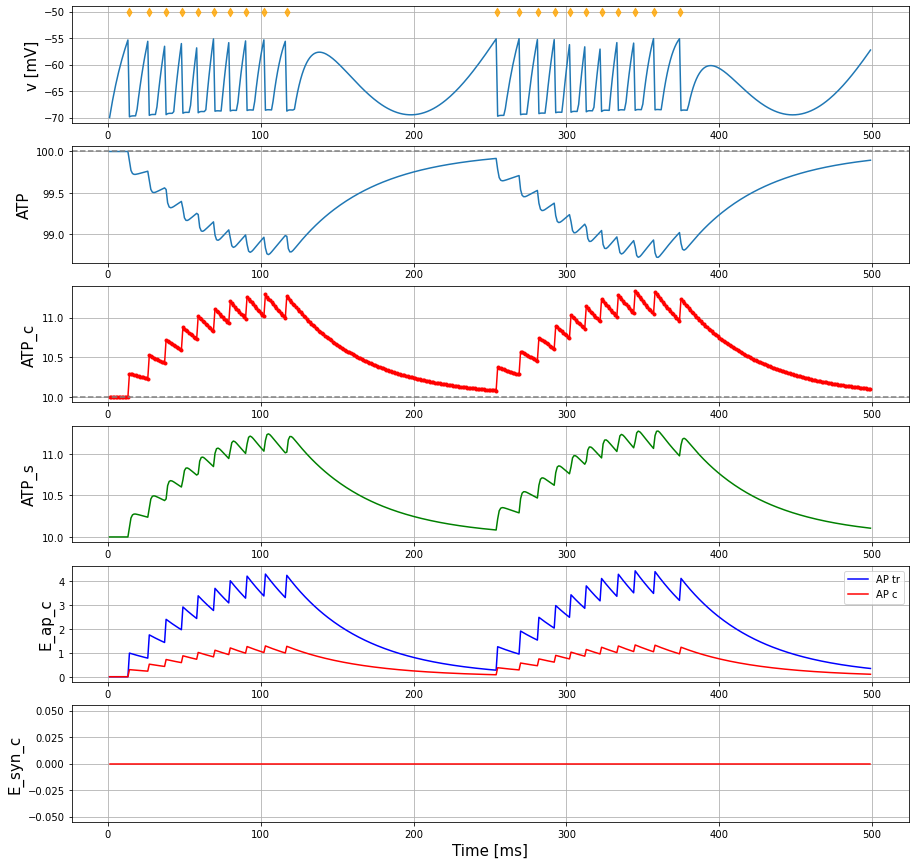

In [6]:
nest.set_verbosity("M_WARNING")
nest.ResetKernel()

# resolution
nest.resolution = 0.1
resolution = nest.GetKernelStatus()["resolution"]
print(f"resolution time: {resolution}") 

neuron_model_name = neuron_model[neuron_id].split(".")[0]
print(f"Using neuron model: {neuron_model_name}")

# current generator
gen = "ac" # dc o ac
print(f"Using {gen} current generator")

neuron = nest.Create(neuron_model_name)
voltmeter = nest.Create("voltmeter")

# change neuron params
neuron.K_ATP = 1

voltmeter.set({"record_from": ["V_m", "ATP", "ATP_c", "ATP_s", "E_ap_tr", "E_ap_c", "E_syn_c"]}) #, "E_ap_der", "E_ap_tr2"]})
nest.Connect(voltmeter, neuron)

if gen == "dc":
    cgs = nest.Create('dc_generator')
    cgs.set({"amplitude": 1.86})
elif gen == "ac":
    cgs = nest.Create('ac_generator')
    cgs.set({"amplitude": 2.2})
    cgs.set({"offset": 2.2})
    cgs.set({"frequency": 4})
    
nest.Connect(cgs, neuron)

sr = nest.Create("spike_recorder")
nest.Connect(neuron, sr)

nest.Simulate(1*500.)

# precision
error = nest.GetStatus(neuron, "gsl_error_tol")
print(f"absolute error of integration: {error}")

spike_times = nest.GetStatus(sr, keys='events')[0]['times']

fontsize = 15
fig, ax = plt.subplots(nrows=6, figsize=(15,15))
ax[0].plot(voltmeter.get("events")["times"], voltmeter.get("events")["V_m"])
ax[1].plot(voltmeter.get("events")["times"], voltmeter.get("events")["ATP"])
ax[1].axhline(y=neuron.get("ATP_h"), c="gray", ls="--")
ax[2].plot(voltmeter.get("events")["times"], voltmeter.get("events")["ATP_c"], c="r", marker ='.')
ax[2].axhline(y=neuron.get("ATP_basal"), c="gray", ls="--")
ax[3].plot(voltmeter.get("events")["times"], voltmeter.get("events")["ATP_s"], c="g")
ax[4].plot(voltmeter.get("events")["times"], voltmeter.get("events")["E_ap_tr"], c="b", label="AP tr")
ax[4].plot(voltmeter.get("events")["times"], voltmeter.get("events")["E_ap_c"], c="r", label="AP c")
#ax[5].plot(voltmeter.get("events")["times"], voltmeter.get("events")["E_ap_tr2"], c="b")
#ax[5].plot(voltmeter.get("events")["times"], voltmeter.get("events")["E_ap_der"], c="r")
ax[5].plot(voltmeter.get("events")["times"], voltmeter.get("events")["E_syn_c"], c="r")
ax[0].scatter(spike_times, -50 * np.ones_like(spike_times), marker="d", c="orange", alpha=.8, zorder=99)
for _ax in ax:
    _ax.grid(True)
ax[0].set_ylabel("v [mV]", fontsize=fontsize)
ax[1].set_ylabel("ATP", fontsize=fontsize)
ax[2].set_ylabel("ATP_c", fontsize=fontsize)
ax[3].set_ylabel("ATP_s", fontsize=fontsize)
ax[4].set_ylabel("E_ap_tr", fontsize=fontsize)
ax[4].set_ylabel("E_ap_c", fontsize=fontsize)
ax[5].set_ylabel("E_syn_c", fontsize=fontsize)
ax[-1].set_xlabel("Time [ms]", fontsize=fontsize)
ax[4].legend()
fig.show()

In [5]:
#nest.kernel_status